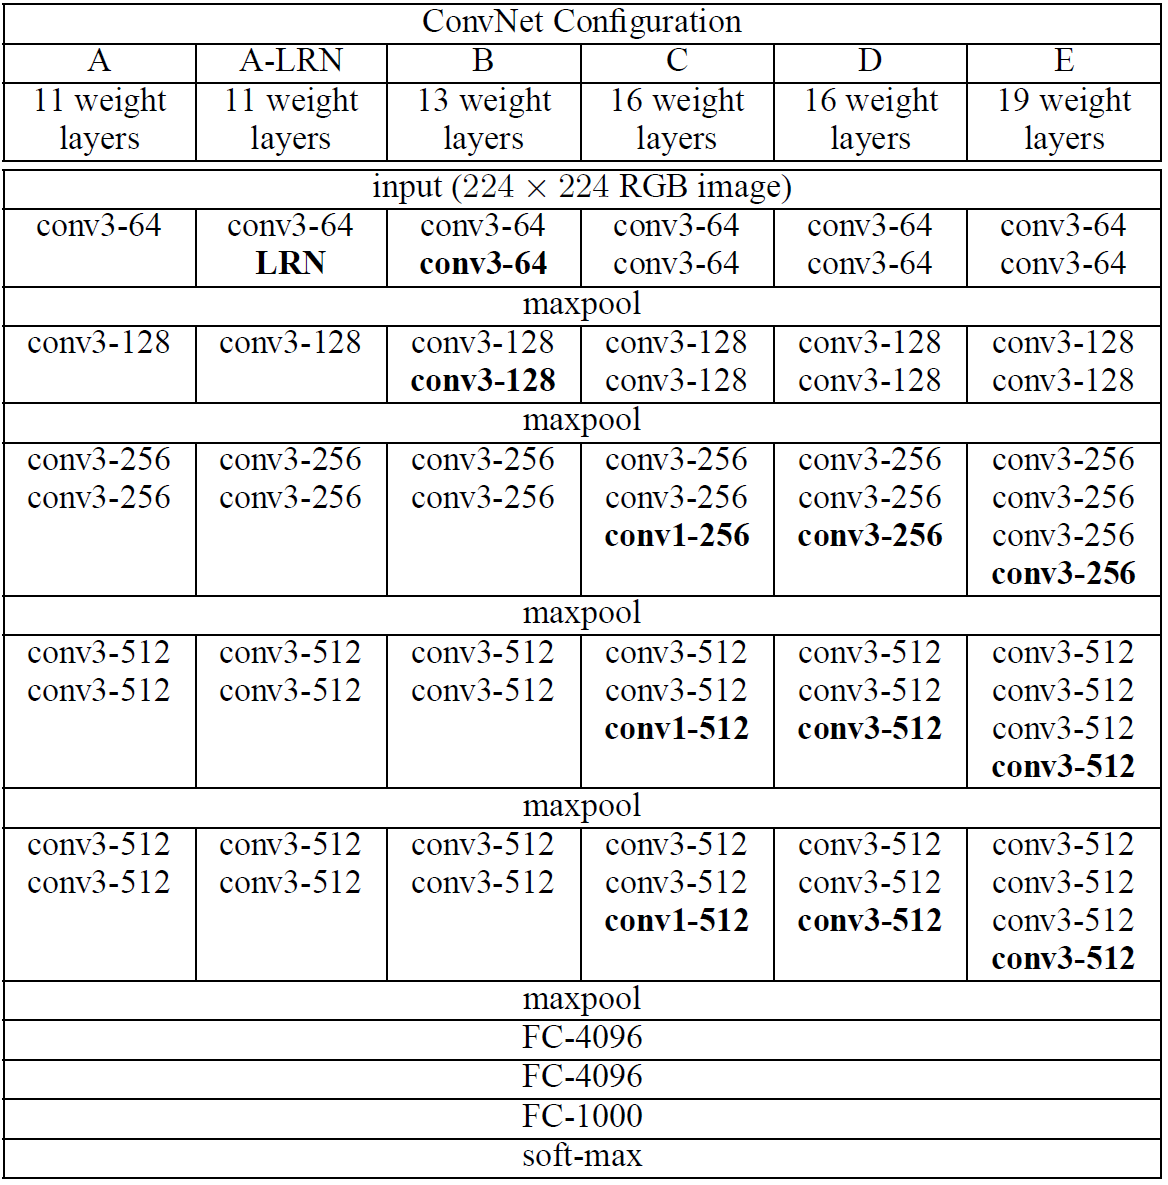

Implementation of VGGNet

VGGNet : VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION <br>
https://arxiv.org/pdf/1409.1556.pdf

In [22]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [23]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


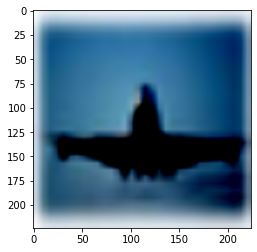

plane


In [25]:
sample_num = 694

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
layer_configs = {
    "A" : [(3,64), 'M', (3,128), 'M', (3,256), (3,256), 'M', (3,512), (3,512), 'M', (3,512), (3,512), 'M'],
    "A-LRN" : [(3,64), 'LRN', 'M', (3,128), 'M', (3,256), (3,256), 'M', (3,512), (3,512), 'M', (3,512), (3,512), 'M'],
    "B" : [(3,64), (3,64), 'M', (3,128), (3,128), 'M', (3,256), (3,256), 'M', (3,512), (3,512), 'M', (3,512), (3,512), 'M'],
    "C" : [(3,64), (3,64), 'M', (3,128), (3,128), 'M', (3,256), (3,256), (1,256), 'M', (3,512), (3,512), (1,512), 'M', (3,512), (3,512), (1,512), 'M'],
    "D" : [(3,64), (3,64), 'M', (3,128), (3,128), 'M', (3,256), (3,256), (3,256), 'M', (3,512), (3,512), (3,512), 'M', (3,512), (3,512), (3,512), 'M'],
    "E" : [(3,64), (3,64), 'M', (3,128), (3,128), 'M', (3,256), (3,256), (3,256), (3,256), 'M', (3,512), (3,512), (3,512), (3,512), 'M', (3,512), (3,512), (3,512), (3,512), 'M'],
}

In [36]:
class VGGNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes, layer_config="A"):
        super().__init__()
        
        layers = layer_configs[layer_config]
        
        self.features = make_layer(in_channels, layers)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((7,7))
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(7*7*512, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)
    
def make_layer(in_channels, layers):
    modules = []
    
    in_channels = in_channels
    for layer_type in layers:
        if layer_type == "M":
            modules.append(nn.MaxPool2d(kernel_size=2, stride=2))
        elif layer_type == "LRN":
            modules.append(nn.LocalResponseNorm(2))
        else:
            k, layer = layer_type
            modules.append(nn.Conv2d(in_channels, layer, kernel_size=k, padding=1))
            modules.append(nn.ReLU(inplace=True))
            in_channels = layer
    
    return nn.Sequential(*modules)

In [41]:
# Type에 따라 모델을 생성할 수 있습니다.
model = VGGNet(3, 10, "E").to(device)
summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [42]:
lr = 1e-5
epochs = 50

In [43]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader): 
        images, targets = images.to(device), targets.to(device)
        
        pred = model(images)
        loss = F.cross_entropy(pred, targets)    
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 30) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    val_loss = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)
        preds = model(images)
        loss = F.cross_entropy(preds, targets)   
        val_loss += loss.item()

        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))


Epoch  0

Train:
[  1/12500] | Loss: 2.30029
[417/12500] | Loss: 2.30286
[833/12500] | Loss: 2.30196
[1249/12500] | Loss: 2.30264
[1665/12500] | Loss: 2.30274
[2081/12500] | Loss: 2.30285
[2497/12500] | Loss: 2.30271
[2913/12500] | Loss: 2.30072
[3329/12500] | Loss: 2.27759
[3745/12500] | Loss: 2.24800
[4161/12500] | Loss: 2.22011
[4577/12500] | Loss: 2.18933
[4993/12500] | Loss: 2.16185
[5409/12500] | Loss: 2.13771
[5825/12500] | Loss: 2.11473
[6241/12500] | Loss: 2.09034
